In [34]:
from utils import * 
import pennylane as qml
import os 
from autoencoder8 import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


emd_comparison =['reconstruction_em_fi','reconstruction_em_em2','reconstruction_em_em4','reconstruction_em_em','reconstruction_em_mix']
fid_comparison = ['reconstruction_fidelity_fi','reconstruction_fidelity_em','reconstruction_fidelity_em2','reconstruction_fidelity_em4','reconstruction_fidelity_mix']
loss_map = {'x':'Mix',
            'i':'Fid',
            'm':'Emd',
            '2':'Emd2',
            '4':'Emd4'}

In [39]:
def get_scores(fold):
    if 'fidelity' in fold:
        comparison_metric = 'fidelity'
        k=0    
    else:
        comparison_metric = 'EM_dist'
        k=1
    reses =[]
    for subfolder in os.listdir(fold):
        df = pd.read_csv(os.path.join(fold,subfolder),header = 0)
        if 'Unnamed: 0' in df.columns:
            df.drop(['Unnamed: 0'],axis = 1, inplace=True)
        if comparison_metric == 'fidelity':
            res ={'model':df.file[0],
                'vloss':df.vloss[0],
                'tloss':df.tloss[0],
                comparison_metric:1-np.mean(df[comparison_metric]),
                'mq':df.mq[0],
                'loss':loss_map[fold[-1]]
                }
        else:            
            res ={'model':df.file[0],
                'vloss':df.vloss[0]/(8-df.mq[0]),
                'tloss':df.tloss[0]/(8-df.mq[0]),
                comparison_metric:np.mean(df[comparison_metric]),
                'mq':df.mq[0],
                'loss':loss_map[fold[-1]]
                }


        reses.append(res)

    return pd.DataFrame(reses)


def plot_comparison(df, metric):
    # Unique models and loss bins
    models = df['model'].unique()
    loss_bins = df['loss'].unique()
    palette1=["#006FB4FF","#208A00", "#A80000", "#FF9100","#A600FF"]
    marker_styles = ['o','X','D','*','v']  # One for each loss_bin
    jitter = [0,0.1,0.2,.3,.4]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot each model + loss bin
    for i, model in enumerate(models):
        model_data = df[df['model'] == model]

        for j, loss_level in enumerate(loss_bins):
            sub_data = model_data[model_data['loss'] == loss_level].sort_values(by='mq')
            sub_data['mq']=sub_data['mq']+jitter[j]
            if sub_data.empty:
                continue
            
            sns.scatterplot(
                data=sub_data, x='mq', y=metric, ax=ax1,
                color=palette1[j], marker=marker_styles[j],
                # sizes=[50000]*len(sub_data)
                s=100, edgecolor="#A0A0A0"
            )
    # Labels
    ax1.set_xlabel("mq")
    a =''
    if metric=='fidelity':
        a='1 - '
    ax1.set_ylabel(f'{a}{metric}')
    # ax2.set_ylabel("Validation Loss (vloss)")
    plt.title(f"{metric} vs mq, colored and shaped by loss")
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker=marker_styles[g], color='w',
            markerfacecolor=palette1[g], markersize=10, label=loss_bins[g])
        for g in range(5)
    ]

    plt.legend(handles=legend_elements, title="Training loss")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


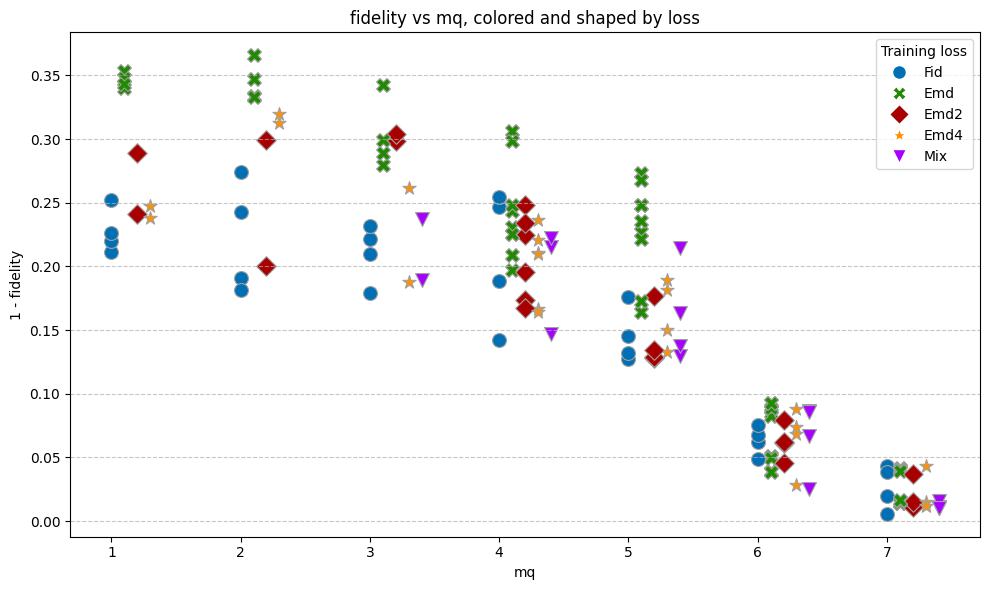

In [32]:
dfs= []
for fold in fid_comparison:
    dfs.append(get_scores(fold))
df = pd.concat(dfs)
plot_comparison(df,'fidelity')

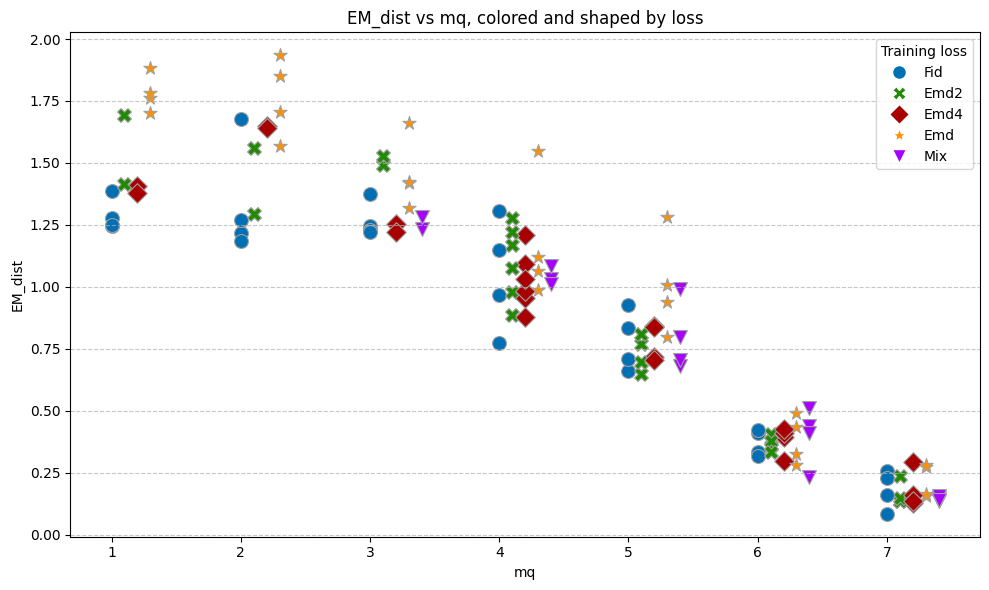

In [40]:
dfs= []
for fold in emd_comparison:
    dfs.append(get_scores(fold))
df = pd.concat(dfs)
plot_comparison(df,'EM_dist')